Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# (Attentive) Neural Processes for 1D regression

Regression is usually cast as modelling the distribution of output **y** given input **x** via a deterministic function, such as a neural network, taking **x** as input. In this setting, the model is trained on a dataset of input-output pairs, and predictions of the outputs are independent of each other given the inputs. An alternative approach to regression involves using the training data to compute a distribution over functions that map inputs to outputs, and using draws from that distribution to make predictions on test inputs. This approach allows for reasoning about multiple functions consistent with the data, and can capture the co-variability in outputs given inputs. In the Bayesian machine learning literature, non-parametric models such as Gaussian Processes (GPs) are popular choices of this approach.

[Neural Processes](https://arxiv.org/abs/1807.01622) (NPs) also approach regression by modelling a distribution over regression functions. Each function models the distribution of the output given an input, conditioning on some observed input-output pairs, which we call the context. Modelling this distribution over functions was made possible by incorporating a latent variable to the [Conditional Neural Process](https://arxiv.org/abs/1807.01613) (CNP). 

However NPs suffer from underfitting, giving inaccurate predictions at the inputs of the observed data they condition on. Hence [Attentive Neural Processes](https://arxiv.org/abs/1901.05761) (ANPs) were introduced, addressing this issue by incorporating attention into NPs. We share the implementation of ANPs (and NPs, which is a special case of ANP with uniform attention) for a 1D regression task where (A)NPs are trained on random 1D functions.

## Imports

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections

## Data generator
Instead of training using observations from a single function (as in classic regression tasks), we would like to train on a dataset that comes from multiple functions with shared characteristics. Hence for training, we use data that comes from a Gaussian Process (GP) with randomly varying kernel parameters.  At each training iteration, we sample a batch of random kernel parameters, and for each parameter setting we sample a curve (a realisation) from the corresponding GP. We select random points on each curve to be the targets and a subset to be the contexts for optimising the training loss. The data generation is almost the same as for the [implementation of CNPs](https://github.com/deepmind/conditional-neural-process/blob/master/conditional_neural_process.ipynb), but with kernel parameters varying randomly at each iteration.

In [0]:
# The (A)NP takes as input a `NPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tensor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

NPRegressionDescription = collections.namedtuple(
    "NPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader(object):
  """Generates curves using a Gaussian Process (GP).

  Supports vector inputs (x) and vector outputs (y). Kernel is
  mean-squared exponential, using the x-value l2 coordinate distance scaled by
  some factor chosen randomly in a range. Outputs are independent gaussian
  processes.
  """

  def __init__(self,
               batch_size,
               max_num_context,
               x_size=1,
               y_size=1,
               l1_scale=0.6,
               sigma_scale=1.0,
               random_kernel_parameters=True,
               testing=False):
    """Creates a regression dataset of functions sampled from a GP.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      random_kernel_parameters: If `True`, the kernel parameters (l1 and sigma) 
          will be sampled uniformly within [0.1, l1_scale] and [0.1, sigma_scale].
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.
    """
    self._batch_size = batch_size
    self._max_num_context = max_num_context
    self._x_size = x_size
    self._y_size = y_size
    self._l1_scale = l1_scale
    self._sigma_scale = sigma_scale
    self._random_kernel_parameters = random_kernel_parameters
    self._testing = testing

  def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
    """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor of shape [B, num_total_points, x_size] with
          the values of the x-axis data.
      l1: Tensor of shape [B, y_size, x_size], the scale
          parameter of the Gaussian kernel.
      sigma_f: Tensor of shape [B, y_size], the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor of shape
      [B, y_size, num_total_points, num_total_points].
    """
    num_total_points = tf.shape(xdata)[1]

    # Expand and take the difference
    xdata1 = tf.expand_dims(xdata, axis=1)  # [B, 1, num_total_points, x_size]
    xdata2 = tf.expand_dims(xdata, axis=2)  # [B, num_total_points, 1, x_size]
    diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

    # [B, y_size, num_total_points, num_total_points, x_size]
    norm = tf.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])

    norm = tf.reduce_sum(
        norm, -1)  # [B, data_size, num_total_points, num_total_points]

    # [B, y_size, num_total_points, num_total_points]
    kernel = tf.square(sigma_f)[:, :, None, None] * tf.exp(-0.5 * norm)

    # Add some noise to the diagonal to make the cholesky work.
    kernel += (sigma_noise**2) * tf.eye(num_total_points)

    return kernel

  def generate_curves(self):
    """Builds the op delivering the data.

    Generated functions are `float32` with x values between -2 and 2.
    
    Returns:
      A `NPRegressionDescription` namedtuple.
    """
    num_context = tf.random_uniform(
        shape=[], minval=3, maxval=self._max_num_context, dtype=tf.int32)

    # If we are testing we want to have more targets and have them evenly
    # distributed in order to plot the function.
    if self._testing:
      num_target = 400
      num_total_points = num_target
      x_values = tf.tile(
          tf.expand_dims(tf.range(-2., 2., 1. / 100, dtype=tf.float32), axis=0),
          [self._batch_size, 1])
      x_values = tf.expand_dims(x_values, axis=-1)
    # During training the number of target points and their x-positions are
    # selected at random
    else:
      num_target = tf.random_uniform(shape=(), minval=0, 
                                     maxval=self._max_num_context - num_context,
                                     dtype=tf.int32)
      num_total_points = num_context + num_target
      x_values = tf.random_uniform(
          [self._batch_size, num_total_points, self._x_size], -2, 2)

    # Set kernel parameters
    # Either choose a set of random parameters for the mini-batch
    if self._random_kernel_parameters:
      l1 = tf.random_uniform([self._batch_size, self._y_size,
                              self._x_size], 0.1, self._l1_scale)
      sigma_f = tf.random_uniform([self._batch_size, self._y_size],
                                  0.1, self._sigma_scale)
    # Or use the same fixed parameters for all mini-batches
    else:
      l1 = tf.ones(shape=[self._batch_size, self._y_size,
                          self._x_size]) * self._l1_scale
      sigma_f = tf.ones(shape=[self._batch_size,
                               self._y_size]) * self._sigma_scale

    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
    kernel = self._gaussian_kernel(x_values, l1, sigma_f)

    # Calculate Cholesky, using double precision for better stability:
    cholesky = tf.cast(tf.cholesky(tf.cast(kernel, tf.float64)), tf.float32)

    # Sample a curve
    # [batch_size, y_size, num_total_points, 1]
    y_values = tf.matmul(
        cholesky,
        tf.random_normal([self._batch_size, self._y_size, num_total_points, 1]))

    # [batch_size, num_total_points, y_size]
    y_values = tf.transpose(tf.squeeze(y_values, 3), [0, 2, 1])

    if self._testing:
      # Select the targets
      target_x = x_values
      target_y = y_values

      # Select the observations
      idx = tf.random_shuffle(tf.range(num_target))
      context_x = tf.gather(x_values, idx[:num_context], axis=1)
      context_y = tf.gather(y_values, idx[:num_context], axis=1)

    else:
      # Select the targets which will consist of the context points as well as
      # some new target points
      target_x = x_values[:, :num_target + num_context, :]
      target_y = y_values[:, :num_target + num_context, :]

      # Select the observations
      context_x = x_values[:, :num_context, :]
      context_y = y_values[:, :num_context, :]

    query = ((context_x, context_y), target_x)

    return NPRegressionDescription(
        query=query,
        target_y=target_y,
        num_total_points=tf.shape(target_x)[1],
        num_context_points=num_context)

## Attentive Neural Processes: a short introduction

Here below are the model diagrams for the **NP** (left) and **ANP** (right).

![](https://i.ibb.co/Js1B7RB/model-figure-new-1-page-001.jpg)

In the NP, the **context points** $(x_C,y_C)=(x_i, y_i)_{i \in C}$ are passed through the encoder that consists of two paths, a **deterministic path** and and a **latent path**. 

In the **deterministic path**, each context pair $(x_i,y_i)$ is passed through an MLP (shared parameters across the contexts) to produce representation $r_i$. These are aggregated by taking the mean to produce the deterministic code $r_C$. 

In the **latent path**, a code $s_C$ is computed in a similar manner from the representations $s_i$, and is used to parameterise the distribution of the latent variable $z$, giving the latent distribution $q(z|s_C)$.

In the decoder, the $r_C$ and $z$ are concatenated alongside $x_*$ and passed through an MLP to produce the parameters of the distribution $p(y_*|x_*,r_C,z)$. 

The motivation for having a global latent is to model different realisations of the data generating stochastic process - each sample of $z$ would correspond to one realisation of the stochastic process. One can define the model using just the deterministic path, just the latent path, or both.

One problem of the NP is that the **mean-aggregation step in the encoder acts as a bottleneck**: since taking the mean across context representations gives the same weight to each context point, it is difficult for the decoder to learn which context points provide relevant information for a given target prediction. 

This is addressed by ANPs, where the mean-aggregation is replaced by a **cross-attention mechanism** - the target query $x_*$ attends to the key-value pairs $(x_i,r_i)_{i \in C}$ and assigns weights $w_i$ to each pair to form a query-specific representation $r_*=\sum_i w_i r_i$. This is precisely where the model allows each query to attend more closely to the context points that it deems relevant for the prediction. Note that if we use uniform attention (all $w_i$ equal), then we revert to the NP.

Another change is the **self-attention mechanism** that replaces the MLPs in the encoder, used in order to model interactions between the context points. However for the 1D regression task here, we do not use self-attention and resort to the MLP setting as it is shown to be sufficient, and just use cross-attention.

Learning for both the NP and ANP is done by optimising the ELBO to the log predictive likelihood:

$$\log p(y_T|x_T,x_C,y_C)  \geq
\mathbb{E}_{q(z|s_T)}  [\log p(y_T|x_T,r_C,z)] - KL ( q(z|s_T) \Vert q(z|s_C) )$$
where $C$ represents contexts and $T$ represents targets.

In [0]:
# utility methods
def batch_mlp(input, output_sizes, variable_scope):
  """Apply MLP to the final axis of a 3D tensor (reusing already defined MLPs).
  
  Args:
    input: input tensor of shape [B,n,d_in].
    output_sizes: An iterable containing the output sizes of the MLP as defined 
        in `basic.Linear`.
    variable_scope: String giving the name of the variable scope. If this is set
        to be the same as a previously defined MLP, then the weights are reused.
    
  Returns:
    tensor of shape [B,n,d_out] where d_out=output_sizes[-1]
  """
  # Get the shapes of the input and reshape to parallelise across observations
  batch_size, _, filter_size = input.shape.as_list()
  output = tf.reshape(input, (-1, filter_size))
  output.set_shape((None, filter_size))

  # Pass through MLP
  with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
    for i, size in enumerate(output_sizes[:-1]):
      output = tf.nn.relu(
          tf.layers.dense(output, size, name="layer_{}".format(i)))

    # Last layer without a ReLu
    output = tf.layers.dense(
        output, output_sizes[-1], name="layer_{}".format(i + 1))

  # Bring back into original shape
  output = tf.reshape(output, (batch_size, -1, output_sizes[-1]))
  return output

## Encoder: Deterministic Path

The encoder in the deterministic path is shared between all context pairs and consists of an MLP and an attention module. Each context $x_i$ and $y_i$ are concatenated and passed through the MLP (with relu non-linearities) to output a representation $r_i$. These $(r_i)_{i \in C}$ and $x_i$ are fed into the cross-attention module, along with query $x_*$ to output a query-specific representation $r_*$. The MLP architecture is given by the `output_sizes` argument, a list of hidden layer sizes, and the `attention` argument which is the cross-attention module defined later on.

In [0]:
class DeterministicEncoder(object):
  """The Deterministic Encoder."""

  def __init__(self, output_sizes, attention):
    """(A)NP deterministic encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      attention: The attention module.
    """
    self._output_sizes = output_sizes
    self._attention = attention

  def __call__(self, context_x, context_y, target_x):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.
      target_x: Tensor of shape [B,target_observations,d_x]. 
          For this 1D regression task this corresponds to the x-values.

    Returns:
      The encoded representation. Tensor of shape [B,target_observations,d]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([context_x, context_y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, 
                       "deterministic_encoder")

    # Apply attention
    with tf.variable_scope("deterministic_encoder", reuse=tf.AUTO_REUSE):
        hidden = self._attention(context_x, target_x, hidden)

    return hidden


## Encoder: Latent Path

The encoder in the latent path is again shared by all context pairs and consists of an MLP.  After the MLP (with relu non-linearities) is applied the resulting representation is aggregated by taking the mean across the contexts and a further MLP is applied to compute the mean and variance of the Gaussian $q(z|s_C)$. Again the initial MLP's architecture is given by the `output_sizes` argument, and the `num_latent` argument sets the latent dimensionality.

In [0]:
class LatentEncoder(object):
  """The Latent Encoder."""

  def __init__(self, output_sizes, num_latents):
    """(A)NP latent encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      num_latents: The latent dimensionality.
    """
    self._output_sizes = output_sizes
    self._num_latents = num_latents

  def __call__(self, x, y):
    """Encodes the inputs into one representation.

    Args:
      x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.

    Returns:
      A normal distribution over tensors of shape [B, num_latents]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([x, y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, "latent_encoder")
      
    # Aggregator: take the mean over all points
    hidden = tf.reduce_mean(hidden, axis=1)
    
    # Have further MLP layers that map to the parameters of the Gaussian latent
    with tf.variable_scope("latent_encoder", reuse=tf.AUTO_REUSE):
      # First apply intermediate relu layer 
      hidden = tf.nn.relu(
          tf.layers.dense(hidden, 
                          (self._output_sizes[-1] + self._num_latents)/2, 
                          name="penultimate_layer"))
      # Then apply further linear layers to output latent mu and log sigma
      mu = tf.layers.dense(hidden, self._num_latents, name="mean_layer")
      log_sigma = tf.layers.dense(hidden, self._num_latents, name="std_layer")
      
    # Compute sigma
    sigma = 0.1 + 0.9 * tf.sigmoid(log_sigma)

    return tf.contrib.distributions.Normal(loc=mu, scale=sigma)


## Decoder

The context representation (either $z$ or $z$ and $r_C$ concatenated) and the target inputs $x_T$ are fed into the decoder. First they are concatenated and passed through an MLP, whose architecture is given by the `output_sizes` argument. The MLP outputs the mean and variance of the Gaussian $p(y_T|x_T,r_C,z)$. 

In [0]:
class Decoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """(A)NP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes

  def __call__(self, representation, target_x):
    """Decodes the individual targets.

    Args:
      representation: The representation of the context for target predictions. 
          Tensor of shape [B,target_observations,?].
      target_x: The x locations for the target query.
          Tensor of shape [B,target_observations,d_x].

    Returns:
      dist: A multivariate Gaussian over the target points. A distribution over
          tensors of shape [B,target_observations,d_y].
      mu: The mean of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
      sigma: The standard deviation of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
    """
    # concatenate target_x and representation
    hidden = tf.concat([representation, target_x], axis=-1)
    
    # Pass final axis through MLP
    hidden = batch_mlp(hidden, self._output_sizes, "decoder")

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tf.contrib.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma

## Model

We can put the encoders and the decoder together to form the ANP model.

In [0]:
class LatentModel(object):
  """The (A)NP model."""

  def __init__(self, latent_encoder_output_sizes, num_latents,
               decoder_output_sizes, use_deterministic_path=True, 
               deterministic_encoder_output_sizes=None, attention=None):
    """Initialises the model.

    Args:
      latent_encoder_output_sizes: An iterable containing the sizes of hidden 
          layers of the latent encoder.
      num_latents: The latent dimensionality.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to d_y * 2
          (it encodes both mean and variance concatenated)
      use_deterministic_path: a boolean that indicates whether the deterministic
          encoder is used or not.
      deterministic_encoder_output_sizes: An iterable containing the sizes of 
          hidden layers of the deterministic encoder. The last one is the size 
          of the deterministic representation r.
      attention: The attention module used in the deterministic encoder.
          Only relevant when use_deterministic_path=True.
    """
    self._latent_encoder = LatentEncoder(latent_encoder_output_sizes, 
                                         num_latents)
    self._decoder = Decoder(decoder_output_sizes)
    self._use_deterministic_path = use_deterministic_path
    if use_deterministic_path:
      self._deterministic_encoder = DeterministicEncoder(
          deterministic_encoder_output_sizes, attention)
    

  def __call__(self, query, num_targets, target_y=None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Tensor of shape [B,num_contexts,d_x]. 
              Contains the x values of the context points.
          context_y: Tensor of shape [B,num_contexts,d_y]. 
              Contains the y values of the context points.
          target_x: Tensor of shape [B,num_targets,d_x]. 
              Contains the x values of the target points.
      num_targets: Number of target points.
      target_y: The ground truth y values of the target y. 
          Tensor of shape [B,num_targets,d_y].

    Returns:
      log_p: The log_probability of the target_y given the predicted
          distribution. Tensor of shape [B,num_targets].
      mu: The mean of the predicted distribution. 
          Tensor of shape [B,num_targets,d_y].
      sigma: The variance of the predicted distribution.
          Tensor of shape [B,num_targets,d_y].
    """

    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    prior = self._latent_encoder(context_x, context_y)
    
    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    if target_y is None:
      latent_rep = prior.sample()
    # For testing, when target_y unavailable, use contexts for latent encoder.
    else:
      posterior = self._latent_encoder(target_x, target_y)
      latent_rep = posterior.sample()
    latent_rep = tf.tile(tf.expand_dims(latent_rep, axis=1),
                         [1, num_targets, 1])
    if self._use_deterministic_path:
      deterministic_rep = self._deterministic_encoder(context_x, context_y,
                                                      target_x)
      representation = tf.concat([deterministic_rep, latent_rep], axis=-1)
    else:
      representation = latent_rep
      
    dist, mu, sigma = self._decoder(representation, target_x)
    
    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y is not None:
      log_p = dist.log_prob(target_y)
      posterior = self._latent_encoder(target_x, target_y)
      kl = tf.reduce_sum(
          tf.contrib.distributions.kl_divergence(posterior, prior), 
          axis=-1, keepdims=True)
      kl = tf.tile(kl, [1, num_targets])
      loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
    else:
      log_p = None
      kl = None
      loss = None

    return mu, sigma, log_p, kl, loss


## Cross-Attention Module
Given a set of key-value pairs $(k_i,v_i)_{i \in I}$ and query $q$, an attention module computes weights for each key and aggregates the values with these weights to form the value corresponding to the query.


**`rep`** determines whether the raw inputs to the module will be used as the keys and queries, or whether you will pass them through an MLP and use the output instead. One of 'identity', 'mlp'.

**`output_sizes`** determines the architecture of the MLP used to obtain the keys/queries if `rep` is 'mlp'.

**`att_type`** is a string argument that determines the type of attention used. Valid choices of attention are: uniform, laplace, dot product, multihead.

* **Uniform** $((k_i,v_i)_{i\in I}, q)= \frac{1}{|I|} \sum_i v_i$

* **Laplace** $((k_i,v_i)_{i\in I}, q)= \sum_i w_i v_i, \hspace{2mm} w_i \propto \exp(-\frac{||q - k_i||_1}{l})$

* **DotProduct** $((k_i,v_i)_{i\in I}, q)= \sum_i w_i v_i, \hspace{2mm} w_i \propto \exp(q^\top k_i / \sqrt{d_k})$ where $k_i \in \mathbb{R}^{d_k}$.

* **Multihead** $((k_i,v_i)_{i\in I}, q)= \mathcal{L}^O(\text{concat}(\text{head}_1, \ldots, \text{head}_H))$, $\text{head}_h = \text{DotProduct}((\mathcal{L}^K_h(k_i),\mathcal{L}^V_h(v_i))_{i \in I}, \mathcal{L}^Q_h(q))$ 

  where $\mathcal{L}$ are linear maps with trainable parameters.

**`scale`**: length scale $l$ in Laplace attention.

**`normalise`**: whether to use a softmax so that weights sum to 1 or not.

**`num_heads`**: $H$, the number of heads for multihead attention.

In [0]:
def uniform_attention(q, v):
  """Uniform attention. Equivalent to np.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    v: values. tensor of shape [B,n,d_v].
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  total_points = tf.shape(q)[1]
  rep = tf.reduce_mean(v, axis=1, keepdims=True)  # [B,1,d_v]
  rep = tf.tile(rep, [1, total_points, 1])
  return rep

def laplace_attention(q, k, v, scale, normalise):
  """Computes laplace exponential attention.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    scale: float that scales the L1 distance.
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  k = tf.expand_dims(k, axis=1)  # [B,1,n,d_k]
  q = tf.expand_dims(q, axis=2)  # [B,m,1,d_k]
  unnorm_weights = - tf.abs((k - q) / scale)  # [B,m,n,d_k]
  unnorm_weights = tf.reduce_sum(unnorm_weights, axis=-1)  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = lambda x: 1 + tf.tanh(x)
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def dot_product_attention(q, k, v, normalise):
  """Computes dot product attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = tf.shape(q)[-1]
  scale = tf.sqrt(tf.cast(d_k, tf.float32))
  unnorm_weights = tf.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = tf.sigmoid
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def multihead_attention(q, k, v, num_heads=8):
  """Computes multi-head attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    num_heads: number of heads. Should divide d_v.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = q.get_shape().as_list()[-1]
  d_v = v.get_shape().as_list()[-1]
  head_size = d_v / num_heads
  key_initializer = tf.random_normal_initializer(stddev=d_k**-0.5)
  value_initializer = tf.random_normal_initializer(stddev=d_v**-0.5)
  rep = tf.constant(0.0)
  for h in range(num_heads):
    o = dot_product_attention(
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wq%d' % h, use_bias=False, padding='VALID')(q),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wk%d' % h, use_bias=False, padding='VALID')(k),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wv%d' % h, use_bias=False, padding='VALID')(v),
        normalise=True)
    rep += tf.layers.Conv1D(d_v, 1, kernel_initializer=value_initializer,
                      name='wo%d' % h, use_bias=False, padding='VALID')(o)
  return rep

class Attention(object):
  """The Attention module."""

  def __init__(self, rep, output_sizes, att_type, scale=1., normalise=True,
               num_heads=8):
    """Create attention module.

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.
    Args:
      rep: transformation to apply to contexts before computing attention. 
          One of: ['identity','mlp'].
      output_sizes: list of number of hidden units per layer of mlp.
          Used only if rep == 'mlp'.
      att_type: type of attention. One of the following:
          ['uniform','laplace','dot_product','multihead']
      scale: scale of attention.
      normalise: Boolean determining whether to:
          1. apply softmax to weights so that they sum to 1 across context pts or
          2. apply custom transformation to have weights in [0,1].
      num_heads: number of heads for multihead.
    """
    self._rep = rep
    self._output_sizes = output_sizes
    self._type = att_type
    self._scale = scale
    self._normalise = normalise
    if self._type == 'multihead':
      self._num_heads = num_heads

  def __call__(self, x1, x2, r):
    """Apply attention to create aggregated representation of r.

    Args:
      x1: tensor of shape [B,n1,d_x].
      x2: tensor of shape [B,n2,d_x].
      r: tensor of shape [B,n1,d].
      
    Returns:
      tensor of shape [B,n2,d]

    Raises:
      NameError: The argument for rep/type was invalid.
    """
    if self._rep == 'identity':
      k, q = (x1, x2)
    elif self._rep == 'mlp':
      # Pass through MLP
      k = batch_mlp(x1, self._output_sizes, "attention")
      q = batch_mlp(x2, self._output_sizes, "attention")
    else:
      raise NameError("'rep' not among ['identity','mlp']")

    if self._type == 'uniform':
      rep = uniform_attention(q, r)
    elif self._type == 'laplace':
      rep = laplace_attention(q, k, r, self._scale, self._normalise)
    elif self._type == 'dot_product':
      rep = dot_product_attention(q, k, r, self._normalise)
    elif self._type == 'multihead':
      rep = multihead_attention(q, k, r, self._num_heads)
    else:
      raise NameError(("'att_type' not among ['uniform','laplace','dot_product'"
                       ",'multihead']"))

    return rep

## Ploting function

Same plotting function as for the [implementation of CNPs](https://github.com/deepmind/conditional-neural-process/blob/master/conditional_neural_process.ipynb) that plots the intermediate predictions every so often during training.

In [0]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
  """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
  """
  # Plot everything
  plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
  plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
  plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
  plt.fill_between(
      target_x[0, :, 0],
      pred_y[0, :, 0] - std[0, :, 0],
      pred_y[0, :, 0] + std[0, :, 0],
      alpha=0.2,
      facecolor='#65c9f7',
      interpolate=True)

  # Make the plot pretty
  plt.yticks([-2, 0, 2], fontsize=16)
  plt.xticks([-2, 0, 2], fontsize=16)
  plt.ylim([-2, 2])
  plt.grid('off')
  ax = plt.gca()
  plt.show()

## Training the (A)NP

We can now start training. First we need to define some variables:

**`TRAINING_ITERATIONS`**: Number of iterations used for trianing. At each iteration we sample a new batch of sample curves from GPs and pick a random set of points on each curve to be the target and a subset to be the context. We optimise the ELBO on the log predictive likelihood of the target given context.

**`MAX_CONTEXT_POINTS`**: Maximum number of context points used during training. This is also set to be the upper bound on the number of target points.

**`PLOT_AFTER`**: The number of iterations between the intermediate plots.

**`HIDDEN_SIZE`**: Master parameter that governs the hidden layer size of all MLPs in the model and also the latent dimensionality. 

**`MODEL_TYPE`**: 'NP' or 'ANP'.

**`ATTENTION_TYPE`**: The type of attention used for ANP. One of `uniform`, `laplace` `dot_product` or `multihead`

**`random_kernel_parameters`**: Boolean to determine whether the GP kernel parameters are sample randomly for each iteration or fixed.


### NP training
First we train the NP. Notice from the plots that the predictions after 1e5 iterations do not go through the context points perfectly - i.e. underfits.

Iteration: 0, loss: 1.0364459753


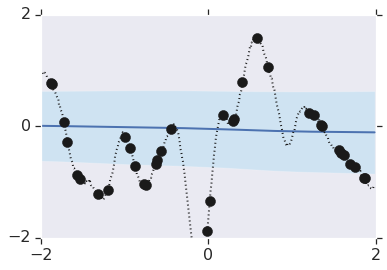

Iteration: 10000, loss: 0.254928678274


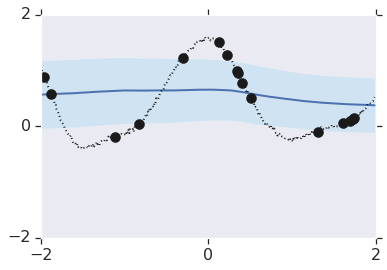

Iteration: 20000, loss: 0.0929502248764


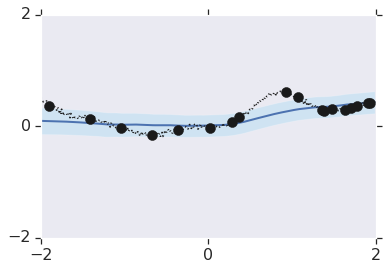

Iteration: 30000, loss: 0.0790428519249


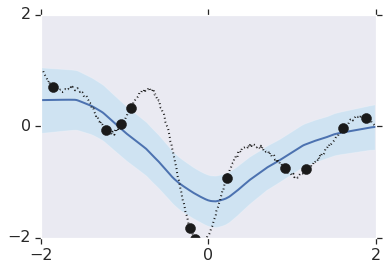

Iteration: 40000, loss: 0.438342481852


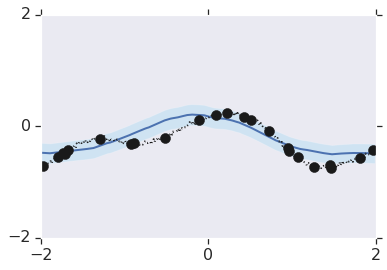

Iteration: 50000, loss: 0.274243146181


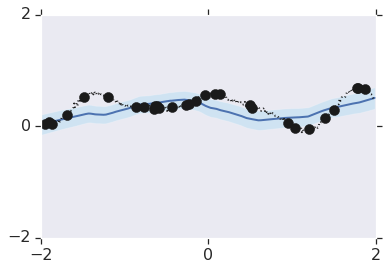

Iteration: 60000, loss: 0.0882532298565


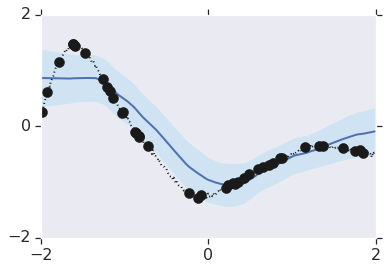

Iteration: 70000, loss: -0.293868511915


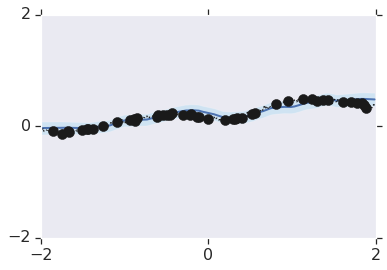

Iteration: 80000, loss: -0.406084805727


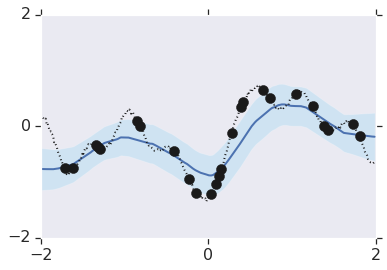

Iteration: 90000, loss: 1.34461963177


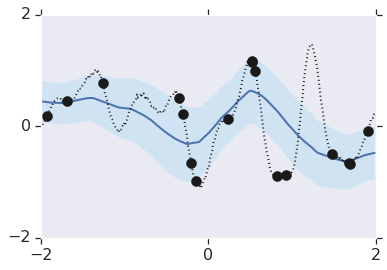

In [0]:
TRAINING_ITERATIONS = 100000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 10000 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'NP' #@param ['NP','ANP']
ATTENTION_TYPE = 'uniform' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

tf.reset_default_graph()
# Train dataset
dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)
data_test = dataset_test.generate_curves()


# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True


# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type=ATTENTION_TYPE)
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)

# Define the loss
_, _, log_prob, _, loss = model(data_train.query, data_train.num_total_points,
                                 data_train.target_y)

# Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, _ = model(data_test.query, data_test.num_total_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
init = tf.initialize_all_variables()

# Train and plot
with tf.Session() as sess:
  sess.run(init)

  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])

    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      loss_value, pred_y, std_y, target_y, whole_query = sess.run(
          [loss, mu, sigma, data_test.target_y, 
           data_test.query])

      (context_x, context_y), target_x = whole_query
      print('Iteration: {}, loss: {}'.format(it, loss_value))

      # Plot the prediction and the context
      plot_functions(target_x, target_y, context_x, context_y, pred_y, std_y)

### ANP training

Next, we train the ANP with multihead attention, using the same hyperparameter setting as NPs. Note that the predictions are now much more accurate for the observed context data.

Iteration: 0, loss: 1.42949461937


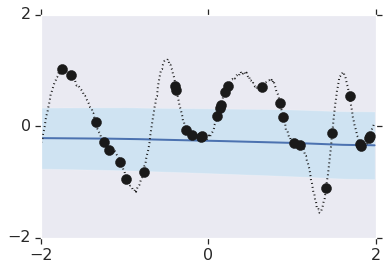

Iteration: 10000, loss: 1.30306947231


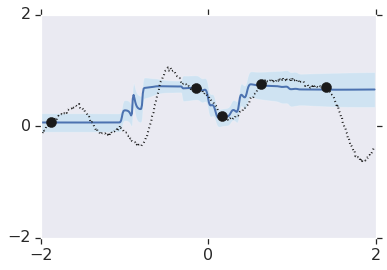

Iteration: 20000, loss: 0.436478257179


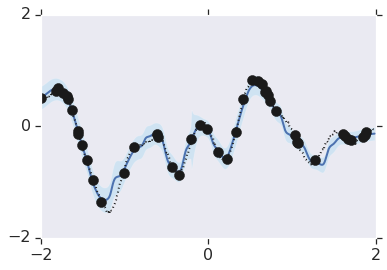

Iteration: 30000, loss: -0.564530730247


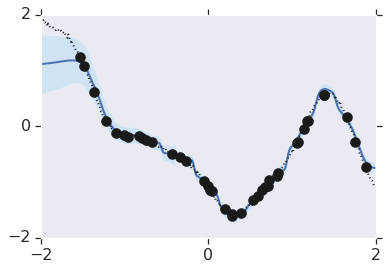

Iteration: 40000, loss: -1.08188056946


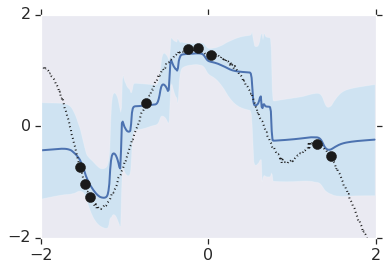

Iteration: 50000, loss: 0.485689043999


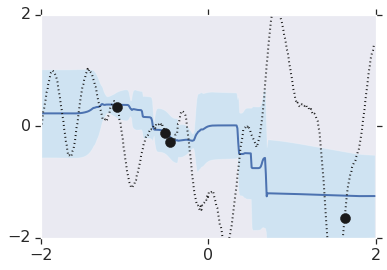

Iteration: 60000, loss: 0.134729295969


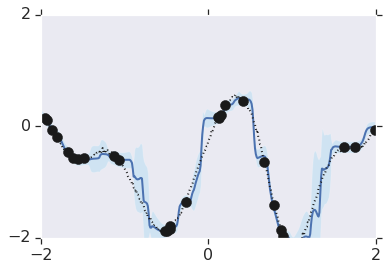

Iteration: 70000, loss: -1.29039406776


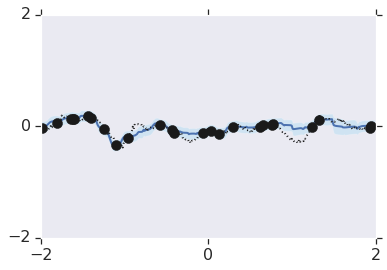

Iteration: 80000, loss: -0.624202787876


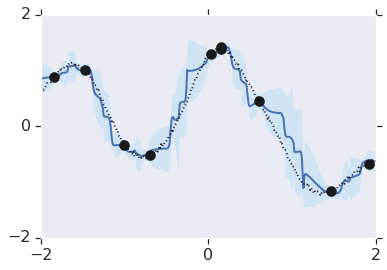

Iteration: 90000, loss: -1.33056414127


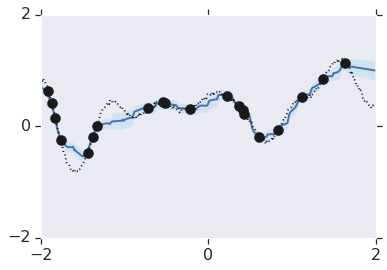

In [0]:
TRAINING_ITERATIONS = 100000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 10000 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'ANP' #@param ['NP','ANP']
ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

tf.reset_default_graph()
# Train dataset
dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)
data_test = dataset_test.generate_curves()


# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True

# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type='multihead')
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)

# Define the loss
_, _, log_prob, _, loss = model(data_train.query, data_train.num_total_points,
                                 data_train.target_y)

# Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, _ = model(data_test.query, data_test.num_total_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
init = tf.initialize_all_variables()

# Train and plot
with tf.train.MonitoredSession() as sess:
  sess.run(init)

  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])

    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      loss_value, pred_y, std_y, target_y, whole_query = sess.run(
          [loss, mu, sigma, data_test.target_y, 
           data_test.query])

      (context_x, context_y), target_x = whole_query
      print('Iteration: {}, loss: {}'.format(it, loss_value))

      # Plot the prediction and the context
      plot_functions(target_x, target_y, context_x, context_y, pred_y, std_y)